In [2]:
import csv
import mechanize as mech
import re
import unicodedata
import scipy.stats as ss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import codecs

#Since we're dealing with non-ascii characters, we'll be needing to specify the unicode encoding a lot
#To make typing slightly easier, I've defined some globals here as shortcuts.
u8 = 'utf-8'
u16 = 'utf-16'

# Getting the Data

## Generate List of Mimetic Vocabulary

The first thing we need to do is get a list of words that are of the mimetic lexical class (at least according to jisho.org). Conveniently, there is already an open-access API for getting word information from jisho.org (a popular dictionary website for Japanese (see second post of this thread: https://jisho.org/forum/54fefc1f6e73340b1f160000-is-there-any-kind-of-search-api). We're going to use the mechanize package to automatically run a search for all words in jisho.org that have the 'onomatopoeic or mimetic word' tag, then save the results to a txt file. The file will look very messy, but we'll extract the relevant information later. 

In [73]:
#open up a .txt file where we can write things to
op=open('jisho_onomatope_raw.txt','w', encoding=u8)


#There are 58 pages of results with the relevant tag (not 0-indexed). 
#We're just going to open up each page of search results, read it, and save it to op.
for i in range(1, 59):
    #use mech.urlopen to quickly access a url
    ur = mech.urlopen("http://jisho.org/api/v1/search/words?keyword=%23on-mim&page={}".format(i))
    
    #use read to convert the result to a format that can be written to a txt file
    contents = ur.read()
    
    #since we're dealing with non-ascii characters, we have to decode the ur.read() result into utf 8 encoding
    op.write(contents.decode(u8))
    
    ur.close()

#close the text file
op.close()

Now we have a file that has the forms we want buried in a sea of gobbledygook. Thankfully, all of the stuff we care about comes after the string 'reading":"', so it's easy to automatically extract. We'll use the .split() function to find everything that comes right after the string 'reading":"', then for each item in the resulting list we'll just take the stuff that comes before the next ".

After that, we'll condense the list of forms to just the unique ones using np.unique(), which returns an array of only the unique entries in a list.

In [82]:
#read the .txt file we just wrote and convert it to a string
jor = open('jisho_onomatope_raw.txt', 'r', encoding = u8)
jor_read= jor.read()
jor.close()

#split it by the string 'reading":"'
split_jor = jor_read.split('reading":"')

#make a list of the relevant forms
formlist = []
for i in split_jor:
    formlist.append(i.split('"')[0])
    
uniq_formlist = np.unique(formlist)

Next, we'll write that list to a txt file. This raw data needs a bit of cleaning which will have to be done by hand. For example, we see that right now the string '{' is in our list, which we know isn't a mimetic word (or any word at all).

In [83]:
f = open('unique_forms.txt', 'w', encoding=u8)

for i in uniq_formlist:
    dum = f.write('\n{}'.format(i))
    
f.close()

## Extracting Corpus Data

Now that we have a list of relevant forms, we're going to run search queries with those forms on a largue corpus, the Balanced Corpus of Contemporary Written Japanese (BCCWJ).

In [3]:
def getVal(ips, targs): #input string, target string
    ind=ips.index(targs)+len(targs)
    notdone=1
    val=''
    while notdone:
        val+=ips[ind]
        ind+=1
        if ips[ind]==',':
            notdone=0
    return val.replace('"','')

In [4]:
#names of relevant variables

#keyword variables
kwvrs = ['"author_name":', '"gender":', '"orth_token":', '"published_year":',
       '"genre1":', '"genre2":','"genre3":', '"genre4":', '"title":',
       '"birth_year":', '"pos":', '"meaning":', '"genre":', '"subcorpus_name":']

#Other variables
othvrs = ['prec', 'foll']

vrdict={} #dictionary of lists of values for each variable
for v in kwvrs:
    vrdict[v]=[]
for v in othvrs:
    vrdict[v]=[]

freqs=[]

#Get list of target mimetic forms
f=open('unique_forms.txt','r', encoding=u8)
#make list of target mimetics
mimset=f.read().split()
f.close()

In [8]:
#Navigate to website

#open browser
br=mech.Browser()
br.open("https://chunagon.ninjal.ac.jp/")

#I have to feed in log in credentials since BCCWJ isn't open-access (it is free to apply for access and use, though)
br.form=list(br.forms())[0]
br.form["username"]="ElectricCassowary"
br.form["password"]="Idoubtanyonewillnoticethatthisisnotmyrealpassword" 
br.submit()

#make sure we're in the right place (corpus list)
assert(br.geturl() == u'https://chunagon.ninjal.ac.jp/')

br.open(u'https://chunagon.ninjal.ac.jp/bccwj-nt/search')

#pre-search setup
lem=(chr(35486)+chr(24409)+chr(32032)) #lemma (goiso)
glob=br.global_form()
glob[u'keywordCondition.items[].key']=[lem] #search by lemma
br.form=br.forms()[0]


#iterate over mimetic words
for mim in mimset:
    #set data parameters
    data={}
    data['retrievalMethod']=b'\xE7\x9F\xAD\xE5\x8D\x98\xE4\xBD\x8D\xE6\xA4\x9C\xE7\xB4\xA2'
    data['condDescription']=b'\xE6\xA4\x9C\xE7\xB4\xA2\xE3\x83\x95\xE3\x82\xA9\xE3\x83\xBC\xE3\x83\xA0\xE3\x81\xA7\xE6\xA4\x9C\xE7\xB4\xA2'
    data['keywordCondition.origin']='' #not sure
    data['keywordCondition.items[0].key']=lem #search condition: lemma
    data['keywordCondition.items[0].val']=mim #search for target word
    data['searchFormOptions.wordSep']='|' #words sep'd by |
    data['searchFormOptions.sentSep']='#' #sentence sep'd by #
    data['searchFormOptions[tglWords]']='10' #number of adjacent context words
    data['searchFormOptions[tglFixVariable]']='2' #no idea what this does
    data['searchFormOptions[limitToSelfSentence]']='1' #look across bun
    data['downloadOptions[encoding]']='UTF-16LE' #encoding
    data['downloadOptions[endOfLine]']='CRLF' #not sure
    data['downloadOptions.notCompressedIfOneFile']='on' #doesn't matter kamo
    data['downloadOptions.splitDownloadFiles']='on' #doesn't matter kamo
    data['downloadOptions[tagSeparator']=',' #DL pos info of context
    data['downloadOptions.inlineTagFeatures']='pos' #pos info
    data['downloadOptions.inlineTagLevels[pos]']='1' #yes, pos info
    data['downloadOptions.inlineTagLevels[ctype]']='1' #no clue
    data['downloadOptions.inlineTagLevels[cform]']='1' #no clue
    
    #set headers
    #req=mech.Request(glob.action+'?download', data=data, method='POST')
    req=mech.Request(glob.action+'?download', data=data, method='POST')
    br.open(req)
    res=br.response()
    params=str(res.get_data()) #string containing GET parameters
    fil=getVal(params, '"file":')
    zp=getVal(params, '"zip":')
    sid=getVal(params, '"session_id":')
    newurl='https://chunagon.ninjal.ac.jp/bccwj-nt/search?download&file={}&zip={}&sid={}'.format(fil,zp,sid)
    newreq=mech.Request(newurl, method='GET')
    br.retrieve(newreq, '{}rawdata.csv'.format(mim))#download file

br.close()

b'{"result":{"zip":false,"file":"7078875003393334124","session_id":"6F67BFCC69F66E9B72283ADAF47A3292.bccwj01","search_log_id":4963005}}'
b'{"result":{"zip":false,"file":"2954014841609328593","session_id":"6F67BFCC69F66E9B72283ADAF47A3292.bccwj01","search_log_id":4963006}}'


# Condensing and ASCIIfying the data

We now have a bunch of files (one for each lemma), so we need to collapse them to a single file.

The data right now is all in Japanese script, so make things easier we're going to convert it all to ascii.

In [106]:
#Open mimetic list input

f=codecs.open('unique_forms.txt',mode='r', encoding='utf-8')

#make list of target mimetics
mimset=f.read().split('\n')

f.close()

alphnumpunc='qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM1234567890!@#$%^&*()-=_+[];:",.<>/?|'

#list of romaji correspondants for hg and kk
#hg will be romanized with lowercase, kk will be romanized with uppercase
romahira=['xa','a','xi','i','xu','u','xe','e','xo','o',
          'ka','ga','ki','gi','ku','gu','ke','ge','ko','go',
          'sa','za','si','zi','su','zu','se','ze','so','zo',
          'ta','da','ti','di','xtu','tu','du','te','de','to','do',
          'na','ni','nu','ne','no',
          'ha','ba','pa','hi','bi','pi','hu','bu','pu','he','be','pe','ho','bo','po',
          'ma','mi','mu','me','mo',
          'xya','ya','xyu','yu','xyo','yo',
          'ra','ri','ru','re','ro',
          'xwa','wa','wi','we','wo','nn','vu','xka','xke']

romakata=[]
for h in romahira:
    romakata.append(h.upper())
        

#hiragana=HIRAGANA LIST range unichr 12353, 12352+87
hiragana=[]
for i in range(12353, 12352+87):
    hiragana.append(chr(i))
#katakana=KATAKANA LIST range unichr 12449, 12449+90
katakana=[]
for i in range(12449, 12449+90):
    katakana.append(chr(i))

In [ ]:
#make a dictionary for converting kanji to ascii
#each kanji will be asciified as 'kX', where X is that kanji's unique index number
#we make two dicts, one that has kanji as keys and ascii as values, and one that's the other way around
kd={}
kd2={}
f=codecs.open('kanjidict.txt',mode='r',encoding=u16)
F=f.read()
f.close()
for line in F.split('\n')[:-1]:
    row=line.split('\t')
    kd[row[1]]=int(row[0])
    kd2[int(row[0])]=row[1]

In [ ]:
#check whether token is hiragana or katakana
def kanaType(tok, binary=True):
    #if binary, treat tok as all one type or other, based on first kana
    if binary:
        if tok[0] in hiragana:
            return 0
        elif tok[0] in katakana:
            return 1
        else:
            return 'kanji'
    
    else:
        hc, kc = 0,0
        for kana in tok:
            if kana in hiragana:
                hc+=1.0
            else:
                kc+=1.0
        return hc/len(tok), kc/len(tok)

def getYear(u):
    if len(u) == 0:
        return 0
    else:
        us = u.split('/')
        for s in us:
            if s.isdigit():
                return int(s)
    return 0
        


def mainread(inp=mimset):
    #7:lemma, 4:kanatype, 30:publishyear, 17:register, 21:authorname,
    #22:authorage, 23:authorgender, 24:genre,
    #25:title, 5:followingcontext, 5:followingcontextPOS
    
    #make lists for lemmas (lem), kana type (korh), year of publication (pubyear),
    #register (regis), author name (authnam), age (authage), and gender (authgen),
    #genre, title, following context (rcon), and the part of speech of the following context (rconpos)
    lem, korh, pubyear, regis, authnam = [],[],[],[],[] 
    authage, authgen, genre, title, rcon, rconpos = [], [], [], [], [], []
    
    
    for mim in inp[:-1]:
        #print mim
        mim=mim.replace(u'\ufeff',u'')
        mim=mim.replace(u'\r',u'')
        #open file and read it
        filename= mim+'rawdata.csv'
        f=codecs.open(filename, mode='r', encoding='utf-16')
        fr=f.read()

        #replace the buggy ni/da thing:
        fr=fr.replace(u'|\u306b[\u3060null\u52a9\u52d5\u8a5e]',u'\u306b[\u306bnull\u52a9\u8a5e]')
        f.close()
        rows=fr.split('\n') #rows of csv doc
        rowc=len(rows) #number of rows
        for row in rows[1:-1]: #ignore first and last row
            cols=row.split('\t')
            ktype=kanaType(cols[4])
            if type(ktype)==int:
                korh.append(kanaType(cols[4])) #kana type
                lem.append(cols[7]) #lemma
                pubyear.append(getYear(cols[30])) #year of publication
                regis.append(cols[17]) #register
                authnam.append(cols[21]) #author name
                authage.append(getYear(cols[22])) #author age (decade of birth)
                authgen.append(cols[23]) #author gender
                genre.append(cols[24]) #genre
                title.append(cols[25]) #publication title

                #parse immediately following context
                rconline=cols[5] #complete rcontext
                rconsplit=rconline.split('|') #split by word boundary |
                if len(rconsplit)>1:
                    immfoll=rconsplit[1].split('[') #split into token and pos
                    if ']' not in immfoll[1]:
                        print immfoll
                    bcon = immfoll[1].split('null') #content in brackets: lem, pos
                    rcon.append(bcon[0]) #token
                    rconpos.append(bcon[1][:bcon[1].index(']')]) #pos ([:-1] deletes final ']')
                else:
                    rcon.append('')
                    rconpos.append('')
    dtype=[('lemma', '<U7'), ('korh', int),('pubyear', int),
           ('register', '<U7'),('authnam', '<U7'),('authage', int),
           ('authgen', '<U7'),('genre','<U7'),('title', '<U7'),
           ('rcon','<U7'),('rconpos', '<U7')]
    allinfo=np.array(zip(lem, korh, pubyear, regis, authnam, authage, authgen,
                         genre, title, rcon, rconpos), dtype=dtype)
    return allinfo, [lem, korh, pubyear, regis, authnam, authage, authgen,
                         genre, title, rcon, rconpos]
            

def asciify(char):
    if type(char)==int:
        return char
    else:
        if char in hiragana:
            return romahira[hiragana.index(char)]
        if char in katakana:
            return romakata[katakana.index(char)]
        if char in alphnumpunc:
            return char
        elif char in kd.keys():
            return 'k{}'.format(kd[char])
    print(char)
    return "ERROR:CHARNOTFOUND"

#take the allinfo output from the mainread() function and write
#it to a txt file, asciifying as we go
def writeasciify(ail):
    f=open('mimorth_data_ascii.txt','w')
    f.write('lemma,kanaType,publishYear,Register,author,authorAge,authorMF,genre,pubtitle,rightContext,rightContextPOS\n')
    for i in range(len(ail[0])):
        for lis in ail:
            targ=lis[i]
            if type(targ)==int:
                f.write(str(targ))
            else:
                for char in targ:
                    f.write(asciify(char))
            f.write(',')
        f.write('\n')
    f.close()

#if we need to read in the data later on, we use this function
def readasciifile(fn='mimorth_data_ascii_subset.csv'):
    rdr= pd.read_csv(fn)
    return rdr

#for each type (lemma), get its percentage odds of being written in katakana
#input is dataframe
def ktypePerc(pddf):
    
    #use np.unique to get each unique token and its number of occurrances in the data
    ulem, ulemc = np.unique(pddf.lemma, return_counts=True)
    
    percd={} #dict of percentage chance of being katakana
    mt=[] #keep track of morphological shape
    
    #for each unique lemma, initialize its percentage chance to 0...
    #... and mark its morphological shape
    for u in ulem:
        percd[u]=0
        mt.append(mimtype(u))
        
    #sum up, for each lemma, instances where that lemma was written in katakana
    for row in range(len(pddf)):
        lm=pddf.lemma[row]
        kt=float(pddf.kanaType[row])
        percd[lm]+=kt
        
    #divide sum by total instances of that lemma to get percent chance
    for ui in range(len(ulem)):
        u=ulem[ui]
        c=ulemc[ui]
        percd[u] = percd[u]/c
        
    return ulem, ulemc, percd, mt

def poscheck(s): #get the part of speech of a token
    if s == 'k115k1802k1528' or s == 'k1802k1528':
        return 'verb'
    elif s == 'k115k1528':
        return 'joushi'
    else:
        return 'other'

#categorize contexts by part of speech
def contextTypeReplace(pddf):
    contexts=[]
    for i in range(len(pddf)):
        con=pddf.rightContext[i]
        pos=pddf.rightContextPOS[i]
        if con == 'da':
            if pos == 'k115k1802k1528': #aux verb
                contexts.append('da')
            else:
                context.append(poscheck(pos))
        elif con == 'to':
            if pos == 'k115k1528': #jousi
                contexts.append('to')
            else:
                context.append(poscheck(pos))
        elif con == 'k1670ru':
            if pos == 'k1802k1528': #dousi
                contexts.append('suru')
            else:
                contexts.append(poscheck(pos))
        else:
            contexts.append(poscheck(pos))
    return contexts

#take list of lemma, sort into lists based on form, return dict of lists
#make dict of types: reduplicated, ri-suffixed, lexicalized -to, nn-suffixed, other
def mimtypeLists(mlist): 
    mtdict = {'redup':[],'rifin':[],'tofin':[],'nnfin':[],'other':[]}
    for w in mlist:
        mt = mimtype(w)
        mtdict[mt].append(w)
    return mtdict

def mimtype(w): #take word, return morphological shape
    haf = len(w)/2 #find midpoint of word
    if w[:haf] == w[haf:]:
        return 'redup' #reduplicated
    elif w[-2:] == 'ri':
        return 'rifin' #-ri suffixed
    elif w[-2:] == 'to':
        return 'tofin' #lexicalized quotative
    elif w[-2:] == 'nn':
        return 'nnfin' #nasal-suffixed
    else:
        return 'other' #everything else

def fixcsv(): #fix errors, add contextype and mimtype
    pddf=pd.read_csv('mimorth_data_ascii - original.csv')
    ctypes=contextTypeReplace(pddf)
    its=len(pddf)
    mt=[]
    for i in range(its):
        lm=pddf.lemma[i]
        mt.append(mimtype(lm))
    return ctypes, mt
    

def dekcode(fname): #take txt file and replace kcodes with english words
    f=open(fname, 'r')
    F=f.read()
    f.close()
    
    codes=['BESUTOSERAk0', 'BUROGU', 'k10k11k12', 'k13k14k14k15k16','k17k18k19', 'k1k2k3k4k2k5', 'k20k21k2', 
           'k22k23', 'k24k2','k25k26k4k27k19', 'k25k26k4k28k29', 'k25k26k4k2k5']
    
    tr=['Best Seller', 'Blog', 'YahooAnswers', 'Diet Records', 'PR Brochure', 'LibraryBook', 'Textbook', 
        'Verse', 'White Paper', 'Magazine', 'Newspaper', 'Book']
    
    for i in range(len(tr)):
        F=F.replace(codes[i], tr[i])
    f = open(fname, 'w')
    f.write(F)
    f.close()

# Analysis

Now that we have our data, we can start doing some analysis. For demonstration here, we're just going to keep it simple and look for some correlations using scipy.stats.

In [141]:
#Read in the .csv file as a dataframe
typedata = pd.read_csv('newdata_blog_nol_lemma.csv')
tokendata = pd.read_csv('newmimorth_data_ascii_cleaned_noAA2.csv')

In [142]:
typedata

,lemma,freq,katap,mimtype,realredup,mt2
0,batann,145,0.648276,nnfin,0,nnfin
1,batinn,14,0.785714,nnfin,0,nnfin
2,baxtutann,5,0.000000,nnfin,0,nnfin
3,bixyunn,1,0.000000,nnfin,0,nnfin
4,bokinn,2,0.000000,nnfin,0,nnfin
5,buk0nn,84,0.785714,nnfin,0,nnfin
6,burunn,47,0.574468,nnfin,0,nnfin
7,bururunn,1,0.000000,nnfin,0,nnfin
8,darann,39,0.333333,nnfin,0,nnfin
9,dodok0nn,16,0.500000,nnfin,0,nnfin


In [160]:
#sort things by the four morphological shape categories: suffixed, redup, nn-final, and other
kvals = {} #kana value
fvals = {} #frequency value

for t in ['suffixed', 'redup', 'nnfin', 'other']:
    kvals[t] = []
    fvals[t] = []
    
for i in range(len(data)):
    if 'fin' in typedata.mimtype[i] and typedata.mimtype[i] != 'nnfin':
        kt = 'suffixed'
    else:
        kt = typedata.mimtype[i]
    kvals[kt].append(typedata.katap[i])
    fvals[kt].append(typedata.freq[i])

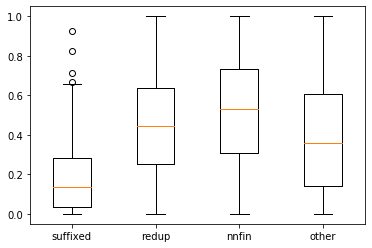

In [161]:
p = plt.boxplot([list(d) for d in kvals.values()])
plt.xticks([1,2,3,4], ['suffixed', 'redup', 'nnfin', 'other'])
plt.show()

suffixed: 0.4364273857199268 (insignificant)


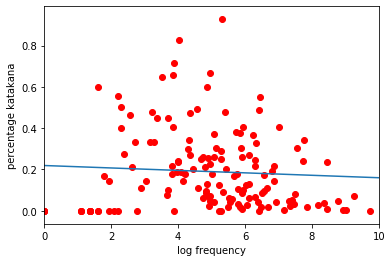

redup: 0.12548397039594048 (insignificant)


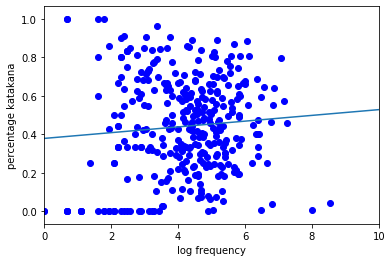

nnfin: 0.02797799872780996 (significant)


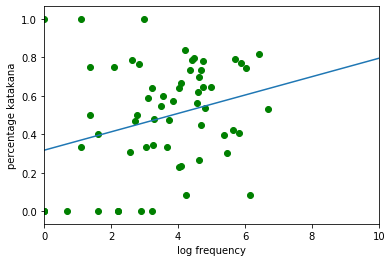

other: 0.27017373476488044 (insignificant)


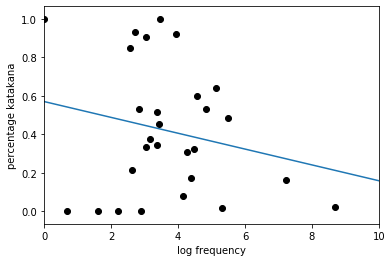

In [175]:
legendcols = {'suffixed':'r', 'redup':'b', 'nnfin':'g', 'other':'k'}

p = plt.plot()

for mtype in kvals.keys():
    plt.xlim(0, 10)
    plt.xlabel('log frequency')
    plt.ylabel('percentage katakana')
    freqs = np.log(np.array(fvals[mtype]))
    slp, cept, rv, pv, sd = ss.linregress(freqs,kvals[mtype])
    if pv <= 0.05:
        print('{}: {} (significant)'.format(mtype, pv))
    else:
        print('{}: {} (insignificant)'.format(mtype, pv))
    plt.scatter(freqs, kvals[mtype], color=legendcols[mtype])
    plt.plot([0, 10], [cept, cept+(10*slp)])
    plt.show()